In [25]:
! pip install tqdm, pygame, pytorchvision


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [1]:
import torch.nn.functional as F
import torch 
from torch import nn
import torch.optim as optim
import torchvision.transforms as T

from torch.distributions import Categorical
import numpy as np
import pandas as pd
import gym

from collections import deque
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
class Actor(nn.Module):
    def __init__(self, input_size, output_size):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(in_features=input_size, out_features=300)
        self.linear2 = nn.Linear(in_features=300, out_features=300)
        self.linear3 = nn.Linear(in_features=300, out_features=output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        output = F.softmax(x, dim=-1)
        return output

class Critic(nn.Module):
    def __init__(self, input_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(in_features=input_size, out_features=300)
        self.linear2 = nn.Linear(in_features=300, out_features=300)
        self.linear3 = nn.Linear(in_features=300, out_features=output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        output = self.linear3(x)
        return output

In [3]:


class CartPoleAC():
    def __init__(self, env, typ="dense"):
      self.env = env
      self.typ = typ
      self.max_episodes = 30000
      self.max_steps = 500
      self.gamma = 0.99
      self.epsilon = 1.0
      self.epsilon_min = 0.001
      self.epsilon_decay_lamda = self.epsilon_min**(1/self.max_episodes)
      self.target_update_counter = 0
      self.target_update_frequency = 10
      self.buffer_minibatch_size = 120
      self.replay_buffer_capacity=5000
      self.replay_buffer = deque([],maxlen=self.replay_buffer_capacity)
      self.resize = T.Compose([T.ToPILImage(),
                    T.Resize(84, interpolation=Image.CUBIC),
                    T.Grayscale(),
                    T.ToTensor()])  
      env.reset()
      _, _, self.state_screen_h, self.state_screen_w = self.screen_preprocessor(self.env.render()).shape
      self.state_count = env.observation_space.shape[0]
      self.action_count = env.action_space.n
      self.actor = Actor(self.state_count, self.action_count) if self.typ=="dense" else None
      self.critic = Critic(self.state_count, 1) if self.typ=="dense" else None
      # self.rms_optimizer = optim.RMSprop(self.q_value_dqn.parameters())#, lr=0.001)#, weight_decay=0.05)
      # self.loss_func = F.smooth_l1_loss
      self.actor_optimizer = optim.SGD(self.actor.parameters(), lr=0.0009)#optim.RMSprop(self.q_value_dqn.parameters(), lr=0.001)#, weight_decay=0.05)
      self.critic_optimizer = optim.SGD(self.critic.parameters(), lr=0.0009)
      self.loss_func = F.mse_loss #F.smooth_l1_loss
      
      self.timestep_list = []
      self.rewards_list = []
      self.epsilon_list = []
      
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      # self.q_value_dqn#.to(self.device)
      # self.target_dqn#.to(self.device)

      self.test_max_episodes = 10
      self.test_timestep_list = []
      self.test_rewards_list = []
      self.test_epsilon_list = []
      self.trained_policy_path = "./actor.pth"

    def initialize_buffer(self):
      for i in range(self.replay_buffer_capacity):
        self.env.reset()
        current_state = self.screen_preprocessor(self.env.render())
        done = False
        while not done:  
          current_action = self.choose_action(current_state)#.to(self.device)
          curr_obs, curr_reward, done, truncated, info = self.env.step(current_action.item())
          next_state = self.screen_preprocessor(self.env.render())

          self.add_to_replay_buffer((current_state, current_action, curr_reward, next_state, done))
          current_state = next_state

    def screen_preprocessor(self,state_screen):
      def crop(variable,tw,th):
         c, h, w = variable.shape
         x1 = int(round((w - tw) / 2.))
         y1 = int(round((h - th) / 2.))
         return variable[:,y1:y1+th,x1:x1+tw]
      state_screen = state_screen.transpose((2,0,1))
      screen_c, screen_h, screen_w = state_screen.shape
      screen = self.resize(torch.from_numpy(state_screen))
      screen = crop(screen, 60, 60)
      screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
      screen = torch.from_numpy(screen)
      return screen.unsqueeze(0)
    
    def choose_action(self, state, test=False):
      random_no = np.random.random()
      if self.epsilon > random_no and not test:
          return torch.tensor([[np.random.choice(self.action_count)]])
      else:
          return self.get_q_value_for_state(state)#.to(self.device))
    
    def get_q_value_for_state(self, state):
      q_values = self.actor(state)
      return q_values.max(1)[1].view(1, 1)

    def eval(self):
      self.actor.load_state_dict(torch.load(self.trained_policy_path))

      for episode in tqdm(range(0, self.test_max_episodes), unit='episodes'):
        obs = self.env.reset()[0]
        done = False
        reward_sum = 0
        steps = 0
        current_state = torch.from_numpy(obs).unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())
        while not done:

          current_action = self.choose_action(current_state, test=True)#.to(self.device)
          curr_obs, curr_reward, done, truncated, info = self.env.step(current_action.item())
          self.env.render()
          
          reward_sum += curr_reward
          next_state = torch.from_numpy(curr_obs).unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())

          steps +=1
          
          current_state = next_state
          if steps==500 or reward_sum==470:
            done=True

        self.test_timestep_list.append(steps)
        self.test_rewards_list.append(reward_sum)


    def train(self, current_state, reward, next_state, done, action_log_prob, I):
      
      current_state_val = self.critic(current_state)
      next_state_val = self.critic(next_state) if not done else 0
  
      delta = reward + self.gamma*next_state_val - current_state_val
      actor_loss = -1*action_log_prob*delta*I
      critic_loss = delta**2

      self.actor_optimizer.zero_grad()
      self.critic.zero_grad()
      
      (actor_loss + critic_loss).backward()
      # critic_loss.backward()
      # for param in self.q_value_dqn.parameters():
      #     param.grad.data.clamp_(-1, 1)
      self.actor_optimizer.step()
      self.critic_optimizer.step()

      return actor_loss.item(), critic_loss.item()
      
    def learn(self):
      
      for episode in tqdm(range(0, self.max_episodes), unit='episodes'):
        obs = self.env.reset()[0]
        done = False
        reward_sum = 0
        steps = 0
        a_running_loss=0
        c_running_loss=0
        I = 1
        current_state = torch.from_numpy(obs).unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())
        while not done:
          action_prob = self.actor(current_state)
          actions_cat = Categorical(action_prob)

          current_action = actions_cat.sample()
          action_log_prob = actions_cat.log_prob(current_action)

          curr_obs, curr_reward, done, truncated, info = self.env.step(current_action.item())

          reward_sum += curr_reward
          
          next_state = torch.from_numpy(curr_obs).unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())
  
          actor_loss, critic_loss = self.train(current_state, curr_reward, next_state, done, action_log_prob, I)
          I = self.gamma*I
          steps +=1
          a_running_loss += actor_loss
          c_running_loss += critic_loss
          current_state = next_state

          if steps==self.max_steps or reward_sum==470:
            done=True

        # self.update_target_net(episode)
            
        self.timestep_list.append(steps)
        self.rewards_list.append(reward_sum)
        self.epsilon_list.append(self.epsilon)
        self.epsilon = max(0.01, self.epsilon*self.epsilon_decay_lamda)
      
        if episode % 100 == 99:
          # print(f"Buffer_size: {len(self.replay_buffer)}|Train_time:{sum(self.tm[-100:])/100}| Sub_t:{sum(self.tr[-100:])/100}")
          # print(f'[Episode: {episode+1}] - Steps: {steps+1} | Rewards: {reward_sum+1} | Epsilon: {self.epsilon} | loss: {running_loss / 10:.3f}')
          print(f'[Episode: {episode+1}] - Steps: {sum(self.timestep_list[-100:])/100} | Rewards: {sum(self.rewards_list[-100:])/100} | Epsilon: {self.epsilon} | loss: {a_running_loss / 10:.3f}, {c_running_loss / 10:.3f}')
          running_loss = 0.0
          if sum(self.rewards_list[-100:])/100 >= 470:
            break
          # p.print()
        
    def update_target_net(self, episode):
       if episode % self.target_update_frequency == self.target_update_frequency-1:   
          self.critic.load_state_dict(self.actor.state_dict())
    
    def get_minibatch_from_replay_buffer(self):
      exp_batch = random.sample(self.replay_buffer, self.buffer_minibatch_size) #max(len(self.replay_buffer), self.buffer_minibatch_size))
      current_state_batch = torch.cat(tuple([exp[0] for exp in exp_batch]),dim=0)
      current_action_batch = torch.cat(tuple([exp[1] for exp in exp_batch]),dim=0)
      next_state_batch = torch.cat(tuple([exp[3] for exp in exp_batch]),dim=0)
      current_reward_batch = torch.tensor(tuple([exp[2] for exp in exp_batch]))#.to(self.device)
      current_done_batch = torch.tensor(tuple([exp[4] for exp in exp_batch]))#.to(self.device)
      return current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch
    
    def add_to_replay_buffer(self, experience):
       self.replay_buffer.append(experience)



In [18]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
env.reset()
agent = CartPoleAC(env)
agent.learn()

  0%|          | 102/30000 [00:11<34:29, 14.44episodes/s] 

[Episode: 100] - Steps: 21.92 | Rewards: 21.92 | Epsilon: 0.9772372209558056 | loss: 1.000, 1.548


  1%|          | 201/30000 [00:19<48:14, 10.30episodes/s]

[Episode: 200] - Steps: 25.24 | Rewards: 25.24 | Epsilon: 0.9549925860214258 | loss: 1.806, 3.356


  1%|          | 301/30000 [00:31<1:26:16,  5.74episodes/s]

[Episode: 300] - Steps: 34.28 | Rewards: 34.28 | Epsilon: 0.933254300796976 | loss: 3.555, 9.188


  1%|▏         | 401/30000 [00:49<1:11:50,  6.87episodes/s]

[Episode: 400] - Steps: 53.28 | Rewards: 53.28 | Epsilon: 0.91201083935589 | loss: 1.846, 4.782


  2%|▏         | 500/30000 [01:13<1:52:51,  4.36episodes/s]

[Episode: 500] - Steps: 64.32 | Rewards: 64.32 | Epsilon: 0.8912509381337214 | loss: 1.976, 6.169


  2%|▏         | 601/30000 [01:37<1:56:17,  4.21episodes/s]

[Episode: 600] - Steps: 71.3 | Rewards: 71.3 | Epsilon: 0.8709635899560526 | loss: 2.574, 12.206


  2%|▏         | 700/30000 [02:02<1:40:45,  4.85episodes/s]

[Episode: 700] - Steps: 74.67 | Rewards: 74.67 | Epsilon: 0.8511380382023443 | loss: 1.107, 4.131


  3%|▎         | 800/30000 [02:28<2:26:08,  3.33episodes/s]

[Episode: 800] - Steps: 75.71 | Rewards: 75.71 | Epsilon: 0.8317637711026356 | loss: 1.295, 8.400


  3%|▎         | 901/30000 [03:09<1:58:22,  4.10episodes/s]

[Episode: 900] - Steps: 81.35 | Rewards: 81.35 | Epsilon: 0.8128305161640605 | loss: 0.681, 5.232


  3%|▎         | 1000/30000 [03:39<12:54:17,  1.60s/episodes]

[Episode: 1000] - Steps: 68.61 | Rewards: 68.61 | Epsilon: 0.79432823472424 | loss: 0.354, 2.821


  4%|▎         | 1100/30000 [04:36<2:55:52,  2.74episodes/s] 

[Episode: 1100] - Steps: 96.82 | Rewards: 96.82 | Epsilon: 0.7762471166286468 | loss: 0.344, 2.033


  4%|▍         | 1200/30000 [05:29<2:48:15,  2.85episodes/s] 

[Episode: 1200] - Steps: 96.94 | Rewards: 96.94 | Epsilon: 0.7585775750291356 | loss: -0.231, 0.435


  4%|▍         | 1300/30000 [06:25<4:17:49,  1.86episodes/s]

[Episode: 1300] - Steps: 111.59 | Rewards: 111.59 | Epsilon: 0.7413102413008664 | loss: 0.146, 0.740


  5%|▍         | 1400/30000 [07:12<3:07:48,  2.54episodes/s]

[Episode: 1400] - Steps: 122.17 | Rewards: 122.17 | Epsilon: 0.7244359600749358 | loss: 1.002, 11.733


  5%|▌         | 1500/30000 [07:59<4:16:58,  1.85episodes/s]

[Episode: 1500] - Steps: 103.52 | Rewards: 103.52 | Epsilon: 0.7079457843840814 | loss: -0.060, 1.017


  5%|▌         | 1600/30000 [08:49<3:18:58,  2.38episodes/s]

[Episode: 1600] - Steps: 120.11 | Rewards: 120.11 | Epsilon: 0.6918309709188775 | loss: 0.133, 4.901


  6%|▌         | 1700/30000 [09:44<5:21:15,  1.47episodes/s] 

[Episode: 1700] - Steps: 112.9 | Rewards: 112.9 | Epsilon: 0.6760829753919201 | loss: 0.318, 2.611


  6%|▌         | 1800/30000 [10:56<4:58:09,  1.58episodes/s] 

[Episode: 1800] - Steps: 162.28 | Rewards: 162.28 | Epsilon: 0.6606934480075326 | loss: 0.357, 7.924


  6%|▋         | 1900/30000 [12:11<6:38:35,  1.17episodes/s]

[Episode: 1900] - Steps: 191.09 | Rewards: 191.09 | Epsilon: 0.6456542290345904 | loss: 0.022, 8.363


  7%|▋         | 2000/30000 [13:34<8:10:59,  1.05s/episodes]

[Episode: 2000] - Steps: 206.1 | Rewards: 206.1 | Epsilon: 0.6309573444801263 | loss: 0.180, 4.715


  7%|▋         | 2100/30000 [14:55<4:58:17,  1.56episodes/s]

[Episode: 2100] - Steps: 196.11 | Rewards: 196.11 | Epsilon: 0.6165950018614137 | loss: -0.021, 1.566


  7%|▋         | 2200/30000 [16:15<6:54:59,  1.12episodes/s]

[Episode: 2200] - Steps: 196.58 | Rewards: 196.58 | Epsilon: 0.602559586074288 | loss: 0.025, 1.244


  8%|▊         | 2300/30000 [17:58<6:13:33,  1.24episodes/s] 

[Episode: 2300] - Steps: 249.81 | Rewards: 249.81 | Epsilon: 0.5888436553555179 | loss: -0.173, 0.828


  8%|▊         | 2400/30000 [19:27<5:17:00,  1.45episodes/s]

[Episode: 2400] - Steps: 213.15 | Rewards: 213.15 | Epsilon: 0.5754399373370849 | loss: 0.022, 1.056


  8%|▊         | 2500/30000 [20:58<5:38:44,  1.35episodes/s]

[Episode: 2500] - Steps: 218.88 | Rewards: 218.88 | Epsilon: 0.5623413251902758 | loss: -0.171, 1.887


  9%|▊         | 2600/30000 [22:27<6:23:32,  1.19episodes/s]

[Episode: 2600] - Steps: 216.15 | Rewards: 216.15 | Epsilon: 0.5495408738575507 | loss: -0.175, 0.561


  9%|▉         | 2700/30000 [23:58<7:52:16,  1.04s/episodes] 

[Episode: 2700] - Steps: 222.01 | Rewards: 222.01 | Epsilon: 0.5370317963701782 | loss: -0.193, 0.463


  9%|▉         | 2800/30000 [25:32<5:38:26,  1.34episodes/s] 

[Episode: 2800] - Steps: 228.23 | Rewards: 228.23 | Epsilon: 0.5248074602496976 | loss: -0.104, 1.189


 10%|▉         | 2900/30000 [27:09<5:43:38,  1.31episodes/s] 

[Episode: 2900] - Steps: 225.51 | Rewards: 225.51 | Epsilon: 0.5128613839912889 | loss: -0.085, 0.635


 10%|█         | 3000/30000 [28:46<6:21:48,  1.18episodes/s] 

[Episode: 3000] - Steps: 231.58 | Rewards: 231.58 | Epsilon: 0.5011872336271957 | loss: -0.512, 0.799


 10%|█         | 3100/30000 [30:27<6:41:39,  1.12episodes/s] 

[Episode: 3100] - Steps: 225.91 | Rewards: 225.91 | Epsilon: 0.48977881936836887 | loss: -0.034, 1.562


 11%|█         | 3200/30000 [32:01<8:33:18,  1.15s/episodes]

[Episode: 3200] - Steps: 223.22 | Rewards: 223.22 | Epsilon: 0.47863009232256 | loss: -0.098, 1.117


 11%|█         | 3300/30000 [33:38<6:10:28,  1.20episodes/s] 

[Episode: 3300] - Steps: 224.9 | Rewards: 224.9 | Epsilon: 0.467735141287119 | loss: -0.074, 0.885


 11%|█▏        | 3400/30000 [35:18<5:58:07,  1.24episodes/s] 

[Episode: 3400] - Steps: 236.43 | Rewards: 236.43 | Epsilon: 0.4570881896147952 | loss: -0.213, 0.394


 12%|█▏        | 3500/30000 [37:07<7:04:04,  1.04episodes/s] 

[Episode: 3500] - Steps: 253.5 | Rewards: 253.5 | Epsilon: 0.4466835921508827 | loss: -0.176, 0.377


 12%|█▏        | 3600/30000 [38:44<9:16:05,  1.26s/episodes]

[Episode: 3600] - Steps: 224.82 | Rewards: 224.82 | Epsilon: 0.4365158322400849 | loss: 0.052, 1.580


 12%|█▏        | 3700/30000 [40:33<8:58:26,  1.23s/episodes] 

[Episode: 3700] - Steps: 250.47 | Rewards: 250.47 | Epsilon: 0.42657951880151124 | loss: -0.073, 1.279


 13%|█▎        | 3800/30000 [42:29<6:42:22,  1.09episodes/s] 

[Episode: 3800] - Steps: 264.1 | Rewards: 264.1 | Epsilon: 0.41686938347025354 | loss: -0.091, 0.194


 13%|█▎        | 3900/30000 [44:19<8:12:24,  1.13s/episodes] 

[Episode: 3900] - Steps: 249.89 | Rewards: 249.89 | Epsilon: 0.4073802778040305 | loss: -0.227, 0.622


 13%|█▎        | 4000/30000 [46:23<11:47:22,  1.63s/episodes]

[Episode: 4000] - Steps: 266.11 | Rewards: 266.11 | Epsilon: 0.3981071705534148 | loss: -0.078, 1.040


 14%|█▎        | 4100/30000 [48:25<9:06:14,  1.27s/episodes] 

[Episode: 4100] - Steps: 272.06 | Rewards: 272.06 | Epsilon: 0.38904514499419784 | loss: -0.056, 0.560


 14%|█▍        | 4200/30000 [50:24<7:13:24,  1.01s/episodes] 

[Episode: 4200] - Steps: 263.86 | Rewards: 263.86 | Epsilon: 0.38018939632047805 | loss: -0.107, 0.717


 14%|█▍        | 4300/30000 [52:18<6:11:02,  1.15episodes/s] 

[Episode: 4300] - Steps: 266.38 | Rewards: 266.38 | Epsilon: 0.37153522909708914 | loss: -0.212, 0.654


 15%|█▍        | 4400/30000 [54:01<7:11:49,  1.01s/episodes] 

[Episode: 4400] - Steps: 252.35 | Rewards: 252.35 | Epsilon: 0.3630780547700179 | loss: -0.076, 0.491


 15%|█▌        | 4500/30000 [55:48<7:25:58,  1.05s/episodes] 

[Episode: 4500] - Steps: 264.63 | Rewards: 264.63 | Epsilon: 0.35481338923349187 | loss: 0.003, 5.101


 15%|█▌        | 4600/30000 [57:33<10:05:54,  1.43s/episodes]

[Episode: 4600] - Steps: 259.79 | Rewards: 259.79 | Epsilon: 0.34673685045244834 | loss: -0.119, 0.339


 16%|█▌        | 4700/30000 [59:18<5:36:59,  1.25episodes/s] 

[Episode: 4700] - Steps: 259.22 | Rewards: 259.22 | Epsilon: 0.33884415613911933 | loss: -0.057, 0.477


 16%|█▌        | 4800/30000 [1:01:01<5:30:15,  1.27episodes/s]

[Episode: 4800] - Steps: 256.68 | Rewards: 256.68 | Epsilon: 0.33113112148250806 | loss: -0.172, 0.679


 16%|█▋        | 4900/30000 [1:02:40<6:16:09,  1.11episodes/s] 

[Episode: 4900] - Steps: 244.04 | Rewards: 244.04 | Epsilon: 0.3235936569295455 | loss: -0.156, 0.830


 17%|█▋        | 5000/30000 [1:04:14<9:38:45,  1.39s/episodes]

[Episode: 5000] - Steps: 235.15 | Rewards: 235.15 | Epsilon: 0.3162277660167557 | loss: 0.077, 2.334


 17%|█▋        | 5100/30000 [1:06:00<8:01:57,  1.16s/episodes] 

[Episode: 5100] - Steps: 263.3 | Rewards: 263.3 | Epsilon: 0.3090295432512767 | loss: -0.014, 0.809


 17%|█▋        | 5200/30000 [1:07:40<5:58:46,  1.15episodes/s] 

[Episode: 5200] - Steps: 250.31 | Rewards: 250.31 | Epsilon: 0.3019951720401198 | loss: -0.082, 0.595


 18%|█▊        | 5300/30000 [1:09:29<8:56:31,  1.30s/episodes] 

[Episode: 5300] - Steps: 265.01 | Rewards: 265.01 | Epsilon: 0.2951209226665569 | loss: -0.113, 1.281


 18%|█▊        | 5400/30000 [1:11:21<8:26:47,  1.24s/episodes] 

[Episode: 5400] - Steps: 276.5 | Rewards: 276.5 | Epsilon: 0.28840315031257935 | loss: -0.076, 0.683


 18%|█▊        | 5500/30000 [1:13:04<9:12:45,  1.35s/episodes]

[Episode: 5500] - Steps: 260.26 | Rewards: 260.26 | Epsilon: 0.2818382931263646 | loss: 0.008, 0.869


 19%|█▊        | 5600/30000 [1:14:50<7:21:55,  1.09s/episodes] 

[Episode: 5600] - Steps: 263.47 | Rewards: 263.47 | Epsilon: 0.27542287033373625 | loss: -0.055, 0.402


 19%|█▉        | 5700/30000 [1:16:40<7:03:02,  1.04s/episodes] 

[Episode: 5700] - Steps: 271.37 | Rewards: 271.37 | Epsilon: 0.26915348039261155 | loss: -0.086, 1.125


 19%|█▉        | 5800/30000 [1:18:38<7:51:22,  1.17s/episodes] 

[Episode: 5800] - Steps: 288.49 | Rewards: 288.49 | Epsilon: 0.26302679918945865 | loss: -0.083, 0.228


 20%|█▉        | 5900/30000 [1:20:39<7:08:39,  1.07s/episodes] 

[Episode: 5900] - Steps: 288.98 | Rewards: 288.98 | Epsilon: 0.2570395782768071 | loss: -0.116, 0.431


 20%|██        | 6000/30000 [1:22:42<8:10:48,  1.23s/episodes] 

[Episode: 6000] - Steps: 295.53 | Rewards: 295.53 | Epsilon: 0.2511886431508792 | loss: -0.132, 0.634


 20%|██        | 6100/30000 [1:24:44<6:23:33,  1.04episodes/s] 

[Episode: 6100] - Steps: 297.08 | Rewards: 297.08 | Epsilon: 0.24547089156842472 | loss: -0.177, 0.419


 21%|██        | 6200/30000 [1:26:41<9:02:02,  1.37s/episodes] 

[Episode: 6200] - Steps: 288.75 | Rewards: 288.75 | Epsilon: 0.23988329190187127 | loss: -0.118, 0.812


 21%|██        | 6300/30000 [1:28:45<7:19:36,  1.11s/episodes] 

[Episode: 6300] - Steps: 299.18 | Rewards: 299.18 | Epsilon: 0.23442288153191498 | loss: -0.062, 0.278


 21%|██▏       | 6400/30000 [1:30:49<9:13:34,  1.41s/episodes] 

[Episode: 6400] - Steps: 292.64 | Rewards: 292.64 | Epsilon: 0.22908676527670066 | loss: -0.011, 0.545


 22%|██▏       | 6500/30000 [1:32:53<6:49:45,  1.05s/episodes] 

[Episode: 6500] - Steps: 300.16 | Rewards: 300.16 | Epsilon: 0.2238721138567579 | loss: -0.074, 0.160


 22%|██▏       | 6600/30000 [1:35:00<8:36:02,  1.32s/episodes] 

[Episode: 6600] - Steps: 298.33 | Rewards: 298.33 | Epsilon: 0.2187761623948797 | loss: -0.083, 0.385


 22%|██▏       | 6700/30000 [1:37:09<9:18:01,  1.44s/episodes] 

[Episode: 6700] - Steps: 309.67 | Rewards: 309.67 | Epsilon: 0.21379620895014828 | loss: -0.080, 0.391


 23%|██▎       | 6800/30000 [1:39:15<7:49:31,  1.21s/episodes] 

[Episode: 6800] - Steps: 294.33 | Rewards: 294.33 | Epsilon: 0.20892961308532967 | loss: -0.033, 0.227


 23%|██▎       | 6900/30000 [1:41:18<7:18:34,  1.14s/episodes] 

[Episode: 6900] - Steps: 291.9 | Rewards: 291.9 | Epsilon: 0.20417379446687922 | loss: -0.068, 0.221


 23%|██▎       | 7000/30000 [1:43:24<9:17:28,  1.45s/episodes] 

[Episode: 7000] - Steps: 295.06 | Rewards: 295.06 | Epsilon: 0.19952623149681473 | loss: -0.032, 0.318


 24%|██▎       | 7100/30000 [1:46:02<15:31:51,  2.44s/episodes]

[Episode: 7100] - Steps: 289.65 | Rewards: 289.65 | Epsilon: 0.194984459975732 | loss: -0.047, 3.826


 24%|██▍       | 7200/30000 [1:49:53<10:58:46,  1.73s/episodes]

[Episode: 7200] - Steps: 297.34 | Rewards: 297.34 | Epsilon: 0.19054607179625285 | loss: -0.107, 0.653


 24%|██▍       | 7300/30000 [1:52:03<8:33:51,  1.36s/episodes] 

[Episode: 7300] - Steps: 310.42 | Rewards: 310.42 | Epsilon: 0.1862087136662154 | loss: -0.251, 0.214


 25%|██▍       | 7400/30000 [1:54:12<7:32:25,  1.20s/episodes] 

[Episode: 7400] - Steps: 303.41 | Rewards: 303.41 | Epsilon: 0.18197008586092747 | loss: -0.084, 0.664


 25%|██▌       | 7500/30000 [1:56:19<9:17:17,  1.49s/episodes] 

[Episode: 7500] - Steps: 310.05 | Rewards: 310.05 | Epsilon: 0.17782794100382204 | loss: -0.185, 0.861


 25%|██▌       | 7600/30000 [1:58:28<7:12:38,  1.16s/episodes] 

[Episode: 7600] - Steps: 305.83 | Rewards: 305.83 | Epsilon: 0.17378008287486799 | loss: -0.096, 0.351


 26%|██▌       | 7700/30000 [2:00:34<10:24:07,  1.68s/episodes]

[Episode: 7700] - Steps: 304.02 | Rewards: 304.02 | Epsilon: 0.16982436524610553 | loss: -0.013, 0.471


 26%|██▌       | 7800/30000 [2:02:42<7:44:47,  1.26s/episodes] 

[Episode: 7800] - Steps: 312.63 | Rewards: 312.63 | Epsilon: 0.16595869074368796 | loss: -0.103, 0.336


 26%|██▋       | 7900/30000 [2:04:53<8:21:23,  1.36s/episodes] 

[Episode: 7900] - Steps: 315.8 | Rewards: 315.8 | Epsilon: 0.16218100973582564 | loss: -0.099, 0.668


 27%|██▋       | 8000/30000 [2:07:04<9:28:25,  1.55s/episodes] 

[Episode: 8000] - Steps: 311.04 | Rewards: 311.04 | Epsilon: 0.15848931924604465 | loss: -0.019, 0.254


 27%|██▋       | 8100/30000 [2:09:20<5:48:38,  1.05episodes/s] 

[Episode: 8100] - Steps: 311.9 | Rewards: 311.9 | Epsilon: 0.15488166189118224 | loss: -0.065, 0.215


 27%|██▋       | 8200/30000 [2:11:26<6:42:38,  1.11s/episodes] 

[Episode: 8200] - Steps: 309.89 | Rewards: 309.89 | Epsilon: 0.15135612484355554 | loss: -0.046, 0.235


 28%|██▊       | 8300/30000 [2:13:17<6:02:42,  1.00s/episodes] 

[Episode: 8300] - Steps: 315.01 | Rewards: 315.01 | Epsilon: 0.14791083881675607 | loss: -0.014, 0.494


 28%|██▊       | 8400/30000 [2:15:04<8:20:16,  1.39s/episodes] 

[Episode: 8400] - Steps: 332.37 | Rewards: 332.37 | Epsilon: 0.14454397707452882 | loss: -0.032, 0.355


 28%|██▊       | 8500/30000 [2:17:32<13:24:46,  2.25s/episodes]

[Episode: 8500] - Steps: 325.85 | Rewards: 325.85 | Epsilon: 0.1412537544622122 | loss: -0.017, 0.415


 29%|██▊       | 8600/30000 [2:20:18<23:40:20,  3.98s/episodes]

[Episode: 8600] - Steps: 330.71 | Rewards: 330.71 | Epsilon: 0.13803842646022607 | loss: -0.226, 0.649


 29%|██▉       | 8700/30000 [2:23:12<12:39:11,  2.14s/episodes]

[Episode: 8700] - Steps: 341.77 | Rewards: 341.77 | Epsilon: 0.13489628825910352 | loss: -0.085, 0.559


 29%|██▉       | 8800/30000 [2:26:12<11:22:06,  1.93s/episodes]

[Episode: 8800] - Steps: 346.34 | Rewards: 346.34 | Epsilon: 0.13182567385557942 | loss: -0.051, 0.321


 30%|██▉       | 8900/30000 [2:28:34<7:12:43,  1.23s/episodes] 

[Episode: 8900] - Steps: 339.24 | Rewards: 339.24 | Epsilon: 0.12882495516925285 | loss: -0.504, 0.723


 30%|███       | 9000/30000 [2:30:45<8:20:34,  1.43s/episodes] 

[Episode: 9000] - Steps: 355.72 | Rewards: 355.72 | Epsilon: 0.12589254117935697 | loss: -0.191, 0.340


 30%|███       | 9100/30000 [2:33:36<10:39:13,  1.84s/episodes]

[Episode: 9100] - Steps: 361.18 | Rewards: 361.18 | Epsilon: 0.12302687708117918 | loss: -0.208, 0.426


 31%|███       | 9200/30000 [2:36:08<6:40:19,  1.15s/episodes] 

[Episode: 9200] - Steps: 359.47 | Rewards: 359.47 | Epsilon: 0.12022644346168297 | loss: -0.014, 0.326


 31%|███       | 9300/30000 [2:38:09<6:39:03,  1.16s/episodes] 

[Episode: 9300] - Steps: 369.07 | Rewards: 369.07 | Epsilon: 0.11748975549389541 | loss: -0.270, 0.246


 31%|███▏      | 9400/30000 [2:40:34<9:08:19,  1.60s/episodes] 

[Episode: 9400] - Steps: 366.25 | Rewards: 366.25 | Epsilon: 0.11481536214963144 | loss: -0.056, 0.237


 32%|███▏      | 9500/30000 [2:42:56<6:32:18,  1.15s/episodes] 

[Episode: 9500] - Steps: 366.35 | Rewards: 366.35 | Epsilon: 0.11220184543014018 | loss: -0.111, 0.176


 32%|███▏      | 9600/30000 [2:45:33<10:53:12,  1.92s/episodes]

[Episode: 9600] - Steps: 367.92 | Rewards: 367.92 | Epsilon: 0.10964781961426295 | loss: -0.034, 0.152


 32%|███▏      | 9700/30000 [2:48:28<6:39:27,  1.18s/episodes] 

[Episode: 9700] - Steps: 381.9 | Rewards: 381.9 | Epsilon: 0.10715193052370572 | loss: -0.022, 0.402


 33%|███▎      | 9800/30000 [2:50:44<7:56:16,  1.41s/episodes] 

[Episode: 9800] - Steps: 364.08 | Rewards: 364.08 | Epsilon: 0.10471285480503573 | loss: -0.036, 0.464


 33%|███▎      | 9900/30000 [2:53:06<7:07:53,  1.28s/episodes]

[Episode: 9900] - Steps: 388.97 | Rewards: 388.97 | Epsilon: 0.1023292992280219 | loss: -0.059, 0.368


 33%|███▎      | 10000/30000 [2:55:33<7:02:45,  1.27s/episodes]

[Episode: 10000] - Steps: 405.28 | Rewards: 405.28 | Epsilon: 0.09999999999994713 | loss: -0.080, 0.416


 34%|███▎      | 10100/30000 [2:58:02<8:51:25,  1.60s/episodes]

[Episode: 10100] - Steps: 405.93 | Rewards: 405.93 | Epsilon: 0.09772372209552882 | loss: -0.165, 0.480


 34%|███▍      | 10200/30000 [3:00:31<8:28:47,  1.54s/episodes] 

[Episode: 10200] - Steps: 409.45 | Rewards: 409.45 | Epsilon: 0.09549925860209199 | loss: -0.105, 0.219


 34%|███▍      | 10300/30000 [3:03:10<8:18:23,  1.52s/episodes] 

[Episode: 10300] - Steps: 435.04 | Rewards: 435.04 | Epsilon: 0.09332543007964822 | loss: -0.120, 0.543


 35%|███▍      | 10400/30000 [3:05:41<7:04:30,  1.30s/episodes] 

[Episode: 10400] - Steps: 420.05 | Rewards: 420.05 | Epsilon: 0.0912010839355408 | loss: -0.259, 0.317


 35%|███▌      | 10500/30000 [3:08:20<8:28:40,  1.57s/episodes] 

[Episode: 10500] - Steps: 417.43 | Rewards: 417.43 | Epsilon: 0.0891250938133251 | loss: -0.038, 0.156


 35%|███▌      | 10600/30000 [3:11:00<8:37:01,  1.60s/episodes]

[Episode: 10600] - Steps: 438.14 | Rewards: 438.14 | Epsilon: 0.08709635899555924 | loss: -0.028, 0.152


 36%|███▌      | 10700/30000 [3:14:40<8:12:39,  1.53s/episodes] 

[Episode: 10700] - Steps: 427.31 | Rewards: 427.31 | Epsilon: 0.08511380382018947 | loss: -0.044, 0.337


 36%|███▌      | 10800/30000 [3:17:18<11:10:58,  2.10s/episodes]

[Episode: 10800] - Steps: 449.49 | Rewards: 449.49 | Epsilon: 0.08317637711021966 | loss: -0.079, 0.199


 36%|███▋      | 10900/30000 [3:20:42<9:11:10,  1.73s/episodes] 

[Episode: 10900] - Steps: 454.21 | Rewards: 454.21 | Epsilon: 0.08128305161636314 | loss: -0.042, 0.825


 37%|███▋      | 11000/30000 [3:23:35<8:25:13,  1.60s/episodes] 

[Episode: 11000] - Steps: 456.48 | Rewards: 456.48 | Epsilon: 0.07943282347238195 | loss: -0.039, 0.100


 37%|███▋      | 11100/30000 [3:26:18<8:34:57,  1.63s/episodes]

[Episode: 11100] - Steps: 456.18 | Rewards: 456.18 | Epsilon: 0.07762471166282363 | loss: -0.027, 0.117


 37%|███▋      | 11200/30000 [3:29:09<7:50:03,  1.50s/episodes] 

[Episode: 11200] - Steps: 460.44 | Rewards: 460.44 | Epsilon: 0.07585775750287344 | loss: -0.210, 3.963


 38%|███▊      | 11300/30000 [3:31:56<8:38:59,  1.67s/episodes] 

[Episode: 11300] - Steps: 465.02 | Rewards: 465.02 | Epsilon: 0.07413102413004746 | loss: -0.093, 1.403


 38%|███▊      | 11400/30000 [3:34:42<8:19:37,  1.61s/episodes] 

[Episode: 11400] - Steps: 459.28 | Rewards: 459.28 | Epsilon: 0.07244359600745533 | loss: -0.118, 0.388


 38%|███▊      | 11500/30000 [3:37:23<8:07:38,  1.58s/episodes]

[Episode: 11500] - Steps: 462.05 | Rewards: 462.05 | Epsilon: 0.07079457843837075 | loss: -0.026, 0.258


 39%|███▊      | 11600/30000 [3:40:06<8:25:37,  1.65s/episodes]

[Episode: 11600] - Steps: 459.22 | Rewards: 459.22 | Epsilon: 0.06918309709185122 | loss: -0.149, 0.102


 39%|███▉      | 11700/30000 [3:42:48<8:16:29,  1.63s/episodes]

[Episode: 11700] - Steps: 461.62 | Rewards: 461.62 | Epsilon: 0.06760829753915637 | loss: -0.162, 0.239


 39%|███▉      | 11800/30000 [3:45:31<8:09:20,  1.61s/episodes]

[Episode: 11800] - Steps: 461.81 | Rewards: 461.81 | Epsilon: 0.06606934480071842 | loss: -0.121, 0.110


 40%|███▉      | 11900/30000 [3:48:15<8:18:01,  1.65s/episodes]

[Episode: 11900] - Steps: 464.63 | Rewards: 464.63 | Epsilon: 0.06456542290342497 | loss: -0.057, 0.119


 40%|████      | 12000/30000 [3:50:58<7:54:01,  1.58s/episodes]

[Episode: 12000] - Steps: 461.38 | Rewards: 461.38 | Epsilon: 0.06309573444797935 | loss: -0.055, 0.125


 40%|████      | 12100/30000 [3:53:52<8:08:21,  1.64s/episodes] 

[Episode: 12100] - Steps: 462.65 | Rewards: 462.65 | Epsilon: 0.06165950018610882 | loss: -0.093, 0.136


 41%|████      | 12200/30000 [3:56:41<8:27:09,  1.71s/episodes] 

[Episode: 12200] - Steps: 466.72 | Rewards: 466.72 | Epsilon: 0.06025595860739694 | loss: -0.069, 0.080


 41%|████      | 12300/30000 [4:01:05<12:58:39,  2.64s/episodes]

[Episode: 12300] - Steps: 469.42 | Rewards: 469.42 | Epsilon: 0.05888436553552064 | loss: -0.133, 0.102


 41%|████▏     | 12400/30000 [4:04:37<11:01:51,  2.26s/episodes]

[Episode: 12400] - Steps: 466.98 | Rewards: 466.98 | Epsilon: 0.057543993733678 | loss: -0.061, 0.064


 42%|████▏     | 12500/30000 [4:07:47<7:14:30,  1.49s/episodes] 

[Episode: 12500] - Steps: 466.67 | Rewards: 466.67 | Epsilon: 0.05623413251899784 | loss: -0.092, 0.132


 42%|████▏     | 12600/30000 [4:10:23<11:31:43,  2.39s/episodes]

[Episode: 12600] - Steps: 464.93 | Rewards: 464.93 | Epsilon: 0.05495408738572593 | loss: -0.047, 0.168


 42%|████▏     | 12700/30000 [4:13:15<6:52:50,  1.43s/episodes] 

[Episode: 12700] - Steps: 467.55 | Rewards: 467.55 | Epsilon: 0.053703179636989264 | loss: -0.017, 0.044


 43%|████▎     | 12800/30000 [4:15:59<9:48:40,  2.05s/episodes] 

[Episode: 12800] - Steps: 467.52 | Rewards: 467.52 | Epsilon: 0.0524807460249418 | loss: -0.141, 0.080


 43%|████▎     | 12900/30000 [4:19:04<8:38:27,  1.82s/episodes] 

[Episode: 12900] - Steps: 465.77 | Rewards: 465.77 | Epsilon: 0.051286138399101566 | loss: -0.125, 0.141


 43%|████▎     | 13000/30000 [4:22:23<8:00:45,  1.70s/episodes] 

[Episode: 13000] - Steps: 467.72 | Rewards: 467.72 | Epsilon: 0.050118723362692824 | loss: -0.077, 1.418


 44%|████▎     | 13100/30000 [4:26:04<10:57:08,  2.33s/episodes]

[Episode: 13100] - Steps: 446.56 | Rewards: 446.56 | Epsilon: 0.04897788193681074 | loss: -0.094, 0.220


 44%|████▍     | 13200/30000 [4:28:37<6:52:47,  1.47s/episodes] 

[Episode: 13200] - Steps: 388.79 | Rewards: 388.79 | Epsilon: 0.04786300923223051 | loss: -0.005, 0.515


 44%|████▍     | 13300/30000 [4:31:01<7:38:09,  1.65s/episodes]

[Episode: 13300] - Steps: 392.7 | Rewards: 392.7 | Epsilon: 0.046773514128687035 | loss: -0.068, 0.645


 45%|████▍     | 13400/30000 [4:33:57<6:38:26,  1.44s/episodes] 

[Episode: 13400] - Steps: 457.55 | Rewards: 457.55 | Epsilon: 0.04570881896145521 | loss: -0.028, 0.158


 45%|████▍     | 13499/30000 [4:37:50<5:39:37,  1.23s/episodes] 

[Episode: 13500] - Steps: 470.0 | Rewards: 470.0 | Epsilon: 0.04466835921506448 | loss: -0.030, 0.097


In [21]:
PATH = './actor.pth'
torch.save(agent.actor.state_dict(), PATH)

In [22]:
PATH = './critic.pth'
torch.save(agent.critic.state_dict(), PATH)

In [23]:
epsilon_list_train_dqn = agent.epsilon_list
reward_list_train_dqn = agent.rewards_list

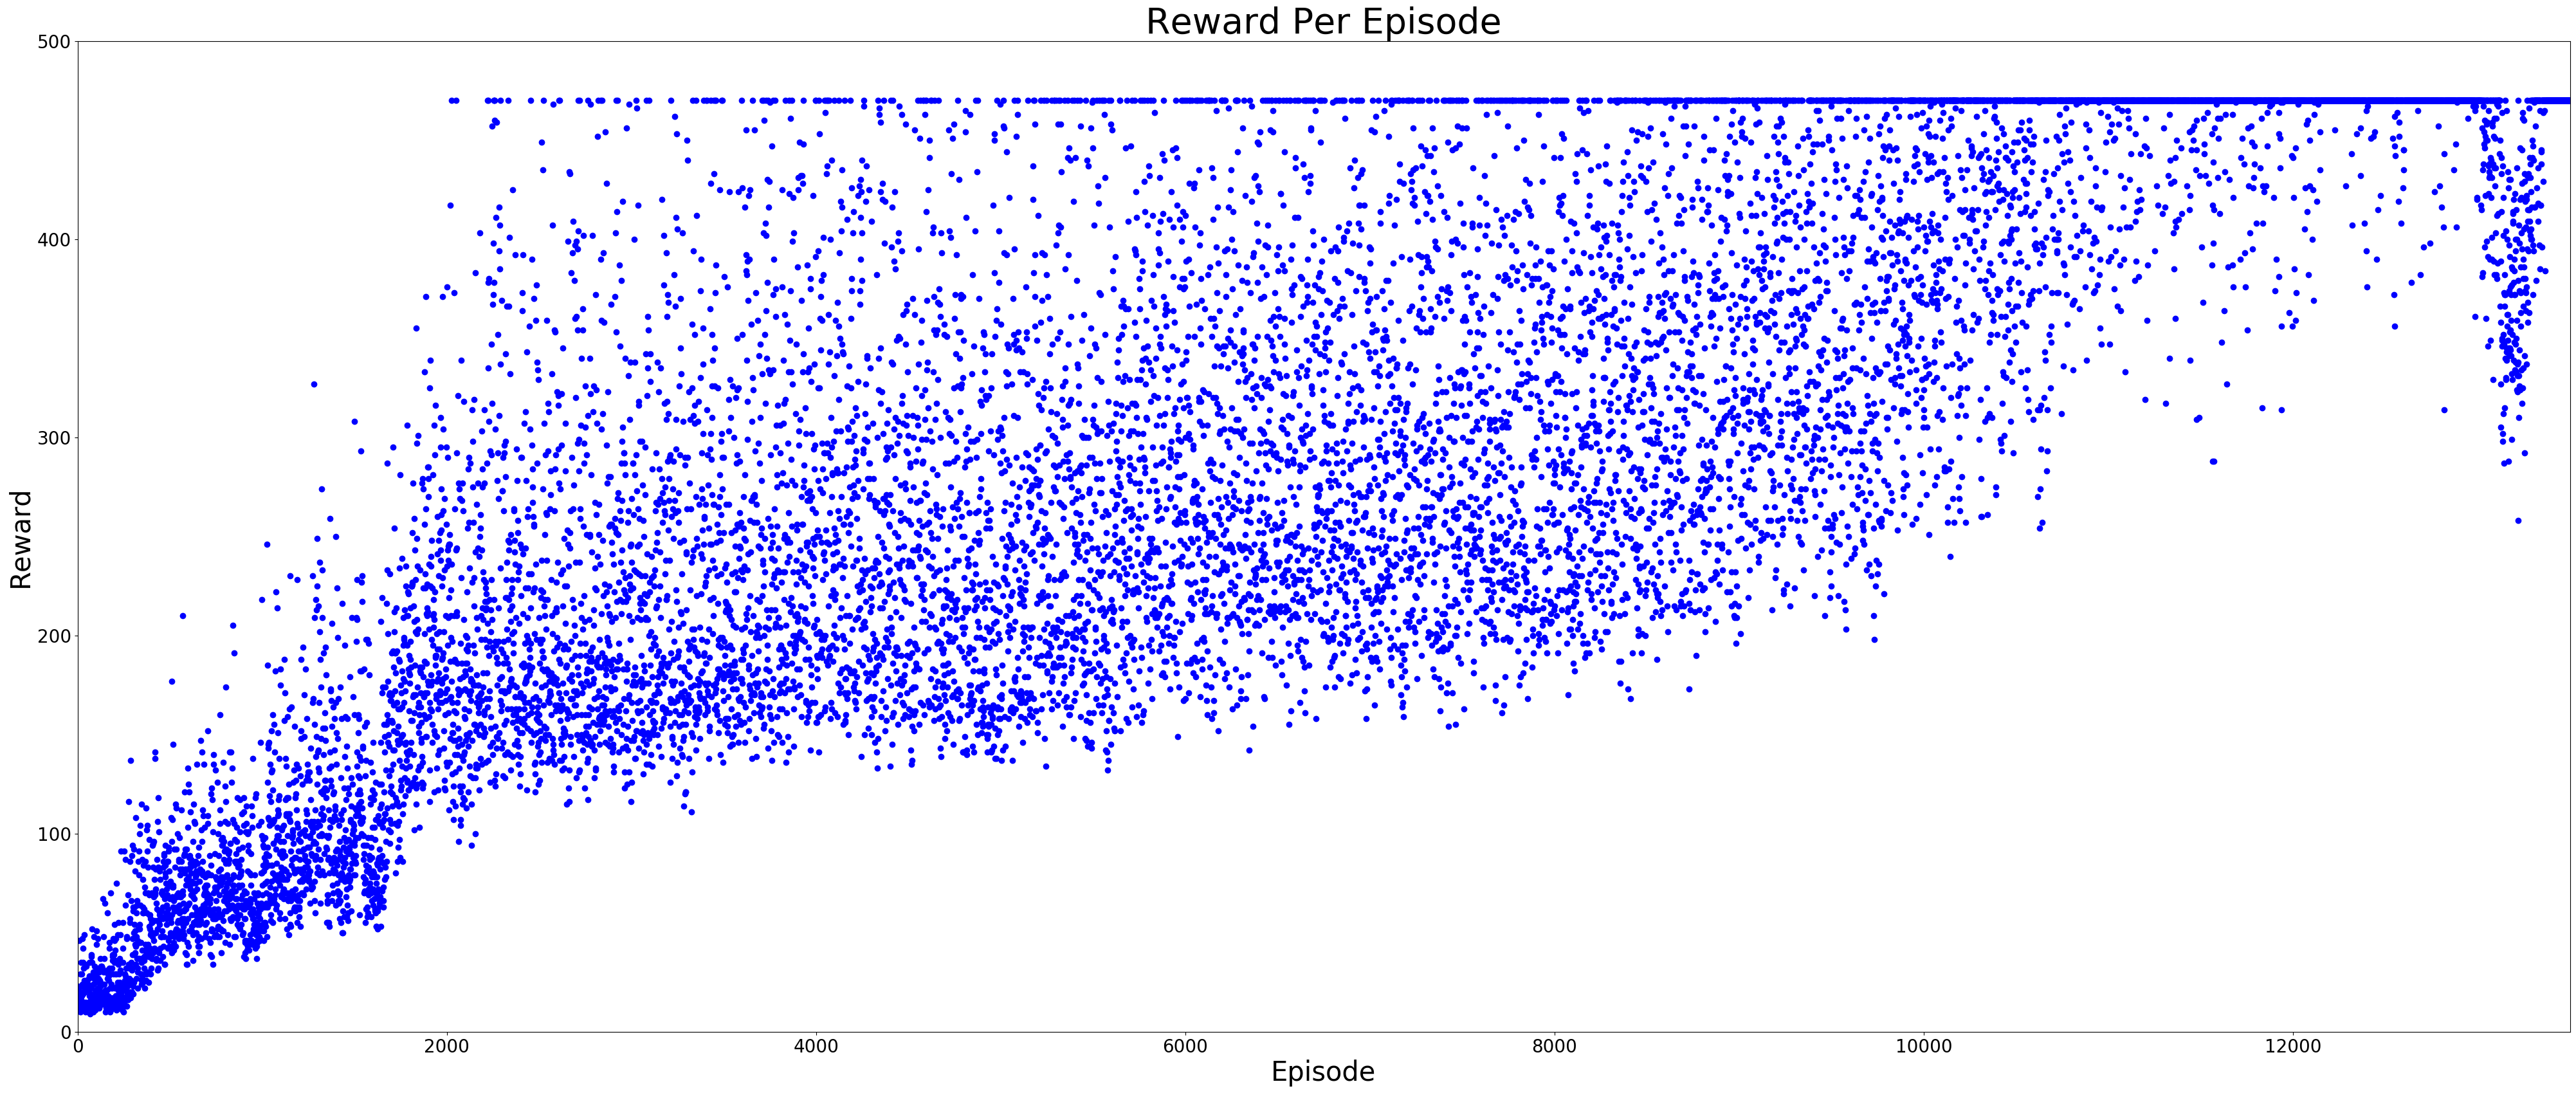

In [27]:
fig, (ax2) = plt.subplots(1,1)
fig.set_figheight(20)
fig.set_figwidth(50)
# ax1.plot(epsilon_list_train_dqn, 'go')
# ax1.set_title("Epsilon Decay", size=40)
# ax1.set_ylabel('Epsilon Value', fontsize = 30) 
# ax1.set_xlabel('Episode', fontsize = 30)
# ax1.tick_params(axis='x', labelsize=20)
# ax1.tick_params(axis='y', labelsize=20)
# ax1.set_xlim(100)
# ax1.set_xlim(xmin=0, xmax=3800)
# ax1.set_ylim(ymin=0, ymax=1)
ax2.plot(reward_list_train_dqn, 'bo')
ax2.set_title(f"Reward Per Episode", size=40)
ax2.set_ylabel('Reward', fontsize = 30) 
ax2.set_xlabel('Episode', fontsize = 30)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xlim(xmin=0, xmax=13500)
ax2.set_ylim(ymin=0, ymax=500)
plt.show()

In [32]:
rewardSD_train_dqn_avg = []
for s in np.split(np.array(reward_list_train_dqn), 135):
    rewardSD_train_dqn_avg.append((sum(s)/len(s)))


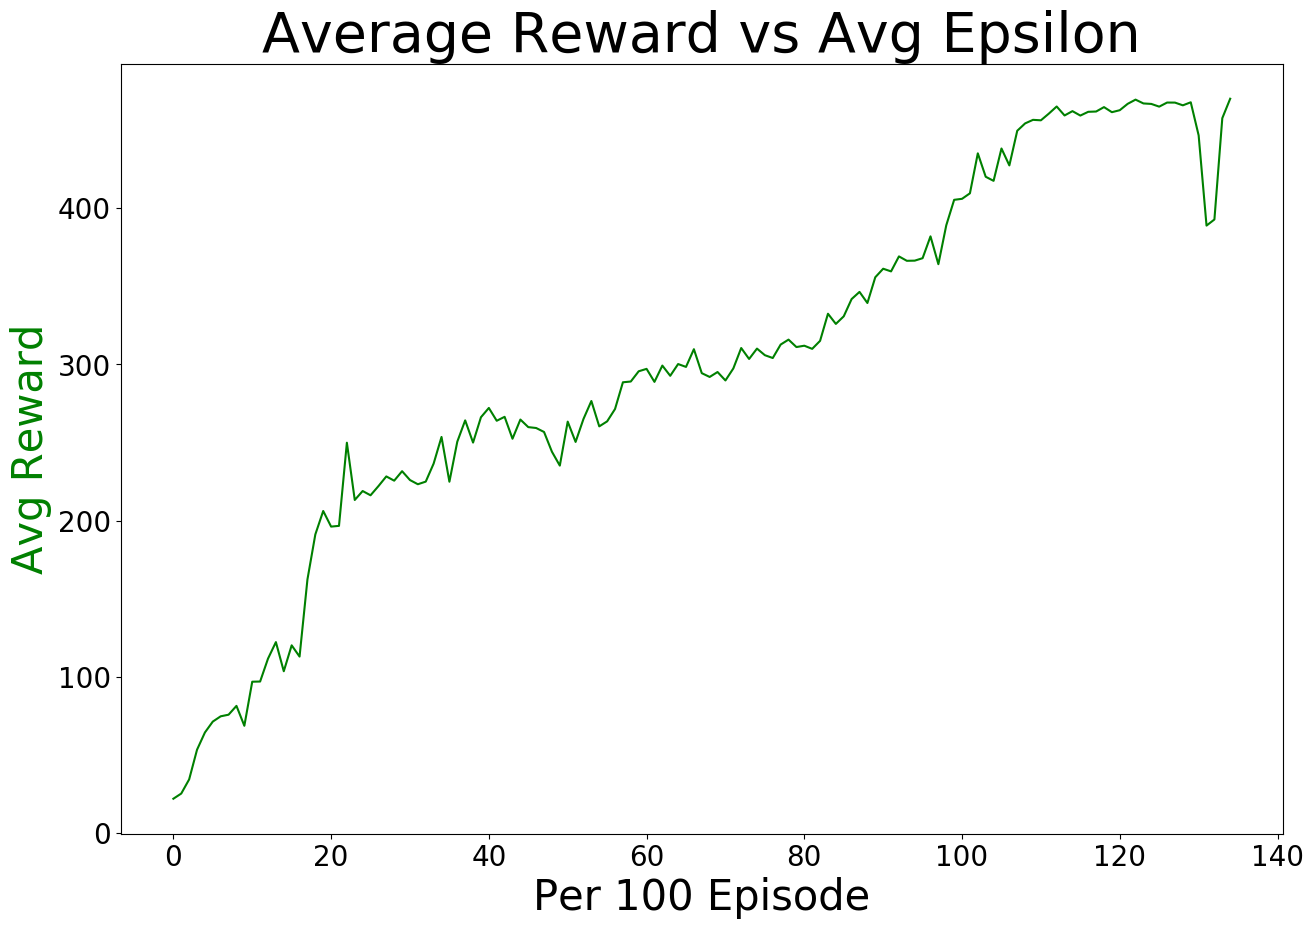

In [33]:
fig, ax2 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
plt.tick_params(axis='both', which='major', labelsize=20)
ax2.plot(rewardSD_train_dqn_avg, 'g-')
ax2.set_title("Average Reward vs Avg Epsilon", size=40)
ax2.set_xlabel('Per 100 Episode', fontsize=30)
ax2.set_ylabel('Avg Epsilon', color='b', fontsize=30)
ax2.set_ylabel('Avg Reward', color='g', fontsize=30)
plt.show()

In [ ]:
import json
with open('reward.json', 'w') as f:
    json.dump(reward_list_train_dqn, f)

# import json
# with open('backup/epsilon.json') as f:
#     epsilon_list_train_dqn = json.load(f)

In [4]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
env.reset()
agent_test = CartPoleAC(env)
agent_test.eval()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
100%|██████████| 10/10 [00:22<00:00,  2.20s/episodes]


In [6]:
reward_list_test_dqn = agent_test.test_rewards_list

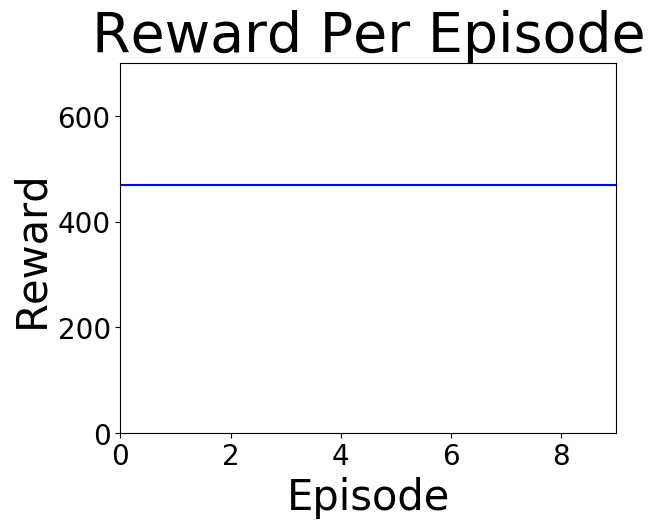

: 

In [12]:
fig, (ax2) = plt.subplots(1,1)
# fig.set_figheight(50)
# fig.set_figwidth(50)
# ax1.plot(epsilon_list_train_dqn, 'go')
# ax1.set_title("Epsilon Decay", size=40)
# ax1.set_ylabel('Epsilon Value', fontsize = 30) 
# ax1.set_xlabel('Episode', fontsize = 30)
# ax1.tick_params(axis='x', labelsize=20)
# ax1.tick_params(axis='y', labelsize=20)
# ax1.set_xlim(100)
# ax1.set_xlim(xmin=0, xmax=3800)
# ax1.set_ylim(ymin=0, ymax=1)
ax2.plot(reward_list_test_dqn, 'b-')
ax2.set_title(f"Reward Per Episode", size=40)
ax2.set_ylabel('Reward', fontsize = 30) 
ax2.set_xlabel('Episode', fontsize = 30)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xlim(xmin=0, xmax=9)
ax2.set_ylim(ymin=0, ymax=700)
plt.show()